In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import re
from torchtext import data, datasets
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
!pip install transformers
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig, BertModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 12.6 MB/s 
     |████████████████████████████████| 7.6 MB 52.2 MB/s 
     |████████████████████████████████| 182 kB 50.3 MB/s 


In [ ]:
def txt_cleaner(string):
    string = re.sub('<[^<]+?>', '', string) #removes html
    string = re.sub(r'[^\w\s]', '', string) #removes everything but letters/numbers and whitespace
    return string.lower() #Makes all characters lowercase
    # Should we implement a method to correct mispellings too? Seems like maybe too much effort...

In [ ]:
#https://github.com/neilpl24/STOR566/data/IMDB Dataset.csv.zip
#https://github.com/neilpl24/STOR566/data/Restaurant_Reviews.tsv

url_test = 'https://raw.githubusercontent.com/neilpl24/STOR566/main/data/Restaurant_Reviews.tsv'
df_test = pd.read_csv(url_test, sep = '\t')
df_test.rename(columns={'Review':'review', 'Liked':'label'}, inplace=True)
df_test["review"] = df_test["review"].apply(txt_cleaner)

In [ ]:
df_test.head()

,review,label
0,wow loved this place,1
1,crust is not good,0
2,not tasty and the texture was just nasty,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1


In [ ]:
url_train = "https://raw.githubusercontent.com/neilpl24/STOR566/main/data/IMDB_Dataset.csv"
df_train = pd.read_csv(url_train)

In [ ]:
# Workaround for if Github link isn't working - put .zip file in your working google drive directory

# import zipfile

# zf = zipfile.ZipFile('IMDB Dataset.csv.zip') 
# df_train = pd.read_csv(zf.open('IMDB Dataset.csv'))

In [ ]:
df_train["label"] = 1
for i in range(len(df_train)):
    if df_train.loc[i, "sentiment"] == "negative":
        df_train.loc[i, "label"] = 0
df_train.drop(columns = ["sentiment"], inplace=True)
df_train["review"] = df_train["review"].apply(txt_cleaner)

In [ ]:
df_train.head()

,review,label
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1


In [ ]:
class TextDataset(Dataset):
    """Text dataset."""

    def __init__(self, df, transform=None):
        """
        Args:
            df (DataFrame): dataframe to work with.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.df.iloc[idx, 1]
        review = self.df.iloc[idx, 0]
        #review = np.array([review])
        #sample = {'review': review, 'label': label}

        if self.transform:
            review = self.transform(review)

        return review, label

In [ ]:
# Padding dataFrame vals to length 256 - either cutting to that length or 0-padding up to it
def padding(df, pad_len):
    '''Zero Pad tokens listed under "review" in a dataset to a pad length and return new dataset'''
    new_df = df[["label"]]
    features = []
    for i in range(len(df)):
        feature = np.zeros(pad_len, dtype=int)
        for v in range(min(pad_len, len(df.loc[i, "review"]))):
            feature[v] = df.loc[i, "review"][v]
        features.append(feature)
    new_df['review'] = [features[j] for j in new_df.index]
    return new_df

In [ ]:
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for batch, _ in data_iter:
        yield tokenizer(batch)

td = TextDataset(df = df_train)

tokenizer = get_tokenizer('basic_english')
train_it = iter(td)

vocab_later = build_vocab_from_iterator(yield_tokens(train_it), specials=[""])
vocab_later.set_default_index(vocab_later[""])


def processing_func(train_df_orig, test_df_orig):
    train_df = train_df_orig
    test_df = test_df_orig

    train_dataset = TextDataset(df = train_df)

    tokenizer = get_tokenizer('basic_english')
    train_iter = iter(train_dataset)

    vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=[""])
    vocab.set_default_index(vocab[""])

    train_df["tokens"] = train_df["review"].apply(lambda x: vocab(tokenizer(x)))
    train_df.drop(["review"], axis = 1, inplace=True)
    train_df.rename(columns = {"tokens":"review"}, inplace=True)
    train_df = train_df[["review", "label"]]

    test_df["tokens"] = test_df["review"].apply(lambda x: vocab(tokenizer(x)))
    test_df.drop(["review"], axis = 1, inplace=True)
    test_df.rename(columns = {"tokens":"review"}, inplace=True)
    test_df = test_df[["review", "label"]]    

    train_df = padding(train_df, 256)
    test_df = padding(test_df, 256)

    return train_df, test_df

In [ ]:
df_train_tokenized, df_test_tokenized = processing_func(df_train, df_test)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_iter = TextDataset(df = df_train_tokenized)
train_dataloader = DataLoader(train_iter, batch_size=16, shuffle=False)
test_iter = TextDataset(df_test_tokenized)
test_dataloader = DataLoader(test_iter, batch_size=16, shuffle=False)

In [ ]:
next(iter(train_dataloader))

[tensor([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0]),
 tensor([[  27,    4,    1,  ...,   19,  610,    2],
         [   3,  382,  113,  ...,    0,    0,    0],
         [   9,  191,   10,  ...,    0,    0,    0],
         ...,
         [   1,  178,  247,  ...,    0,    0,    0],
         [  10,    3,  786,  ...,    0,    0,    0],
         [ 235,    4, 1528,  ...,    0,    0,    0]])]

In [ ]:
# https://bhadreshpsavani.medium.com/tutorial-on-sentimental-analysis-using-pytorch-b1431306a2d7

class SentimentalRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):    
        """
        Initialize the model by setting up the layers
        """
        super().__init__()
        self.output_size=output_size
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        
        #Embedding
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.rnn=nn.RNN(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        #dropout layer
        self.dropout=nn.Dropout(0.3)
        
        #Linear and sigmoid layer
        self.fc1=nn.Linear(hidden_dim, 64)
        self.fc2=nn.Linear(64, 16)
        self.fc3=nn.Linear(16,output_size)
        self.sigmoid=nn.Sigmoid()
        
    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size=x.size()
        
        #Embadding and LSTM output
        embedd=self.embedding(x)
        lstm_out, hidden=self.rnn(embedd)
        
        #stack up the lstm output
        lstm_out=lstm_out.contiguous().view(-1, self.hidden_dim)
        
        #dropout and fully connected layers
        out=self.dropout(lstm_out)
        out=self.fc1(out)
        out=self.dropout(out)
        out=self.fc2(out)
        out=self.dropout(out)
        out=self.fc3(out)
        sig_out=self.sigmoid(out)
        
        sig_out=sig_out.view(batch_size, -1)
        sig_out=sig_out[:, -1]
        
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        """Initialize Hidden STATE"""
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
 
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        
        return hidden

So as you can kind of see above, the way the batches seem to be coming out is as a list of (0, tensor), where the zero is just a placeholder (not sure why it's there) and tensor that contains 2 subtensors. If you index as "zero, batch in enumerate(dataloader)", during training, you'll get the batch in the tensor. The tensor contents are as follows:

1st sub-tensor: The labels for the batch; 1 is positive, 0 is negative.

2nd sub-tensor: A list of lists, where each list is a length-256 0-padded tokenized review that corresponds to the order of the labels.

This means that each observation can be represented as follows:

Observation i in batch:

reviews=batch[1]

labels=batch[0]

review_i = reviews[i]

label_i = labels[i]

In [ ]:

num_epochs = 10
lr = 0.0001

loss_func = nn.BCEWithLogitsLoss()
vocab_sz = vocab_later.__len__() + 1
output_sz = 1
embed_dim = 400
h_dim = 256
n_layer = 2

basic_rnn_mod = SentimentalRNN(vocab_sz, output_sz, embed_dim, h_dim, n_layer).cuda()

optimizer = torch.optim.Adam(basic_rnn_mod.parameters(), lr=lr)

epoch_train_losses = []
epoch_test_losses = []

basic_rnn_mod.train()

for epoch in range(num_epochs):
    print(epoch)
    batch_losses = []
    for i, batch in enumerate(train_dataloader):
        labels = batch[0].cuda()
        reviews = batch[1].cuda()
        output, h = basic_rnn_mod(reviews)
        loss = loss_func(output.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
        avg = np.mean(batch_losses)
    epoch_train_losses.append(avg)

for epoch in range(num_epochs):
    print(epoch)
    batch_losses = []
    for i, batch in enumerate(test_dataloader):
        labels = batch[0].cuda()
        reviews = batch[1].cuda()
        output, h = basic_rnn_mod(reviews)
        loss = loss_func(output.squeeze(), labels.float())
        batch_losses.append(loss.item())
        avg = np.mean(batch_losses)
    epoch_test_losses.append(avg)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [ ]:
import matplotlib.pyplot as plt
epochs = [1,2,3,4,5,6,7,8,9,10]
plt.figure(dpi=300)
plt.plot(epochs, epoch_train_losses, label = "Avg Training Loss")
plt.plot(epochs, epoch_test_losses, label = "Avg Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Avg Epoch Loss")
plt.title("Avg Loss vs. Epoch")
plt.legend()
plt.show()

In [ ]:
basic_rnn_mod.eval()
correct = []
for epoch in range(num_epochs):
    print(epoch)
    batch_losses = []
    for i, batch in enumerate(train_dataloader):
        labels = batch[0].cuda()
        reviews = batch[1].cuda()
        output, h = basic_rnn_mod(reviews)
        loss = loss_func(output.squeeze(), labels.float())
        preds = output
        for i, pred in enumerate(preds):
          if preds[i].round() == labels[i]:
            correct.append(1)
          else:
            correct.append(0)
print(f'Accuracy: {sum(correct)/len(correct)}')

0
1
2
3
4
5
6
7
8
9
Accuracy: 0.50696


In [ ]:
basic_rnn_mod.eval()
correct = []
for epoch in range(num_epochs):
    print(epoch)
    batch_losses = []
    for i, batch in enumerate(test_dataloader):
        labels = batch[0].cuda()
        reviews = batch[1].cuda()
        output, h = basic_rnn_mod(reviews)
        loss = loss_func(output.squeeze(), labels.float())
        preds = output
        for i, pred in enumerate(preds):
          if preds[i].round() == labels[i]:
            correct.append(1)
          else:
            correct.append(0)
print(f'Accuracy: {sum(correct)/len(correct)}')

0
1
2
3
4
5
6
7
8
9
Accuracy: 0.5


# BERT

In [ ]:
#https://github.com/neilpl24/STOR566/data/IMDB Dataset.csv.zip
#https://github.com/neilpl24/STOR566/data/Restaurant_Reviews.tsv

url_test = 'https://raw.githubusercontent.com/neilpl24/STOR566/main/data/Restaurant_Reviews.tsv'
df_test = pd.read_csv(url_test, sep = '\t')
df_test.rename(columns={'Review':'review', 'Liked':'label'}, inplace=True)
df_test["review"] = df_test["review"].apply(txt_cleaner)

In [ ]:
url_train = "https://raw.githubusercontent.com/neilpl24/STOR566/main/data/IMDB_Dataset.csv"
df_train = pd.read_csv(url_train)

In [ ]:
df_train["label"] = 1
for i in range(len(df_train)):
    if df_train.loc[i, "sentiment"] == "negative":
        df_train.loc[i, "label"] = 0
df_train.drop(columns = ["sentiment"], inplace=True)
df_train["review"] = df_train["review"].apply(txt_cleaner)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_data = tokenizer.batch_encode_plus(
    df_train.review.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

test_data = tokenizer.batch_encode_plus(
    df_test.review.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_train = train_data['input_ids']
attention_masks_train = train_data['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_test= test_data['input_ids']
attention_masks_test = test_data['attention_mask']
labels_test = torch.tensor(df_test.label.values)

In [ ]:
train_dataset = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

test_dataset = TensorDataset(input_ids_test, 
                            attention_masks_test,
                           labels_test)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
                                      'bert-base-uncased', 
                                      num_labels = 2,
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
batch_size = 16

train_dataloader = DataLoader(
    train_dataset,
    batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size,
    shuffle=True
)

In [ ]:
torch.cuda.empty_cache()
lr = 0.00003
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.BCEWithLogitsLoss().cuda()
num_epochs = 5

epoch_train_losses = []
epoch_test_losses = []

model.cuda()
model.train()

for epoch in range(num_epochs):
    print(epoch)
    batch_losses = []
    for i, batch in enumerate(train_dataloader):
        input_ids = batch[0].cuda()
        attention_masks = batch[1].cuda()
        labels = batch[2].cuda()
        outputs = model(input_ids, attention_masks, labels=labels)
        loss = outputs[0]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        batch_losses.append(loss.item())
        avg = np.mean(batch_losses)
    print(avg)
    epoch_train_losses.append(avg)



0
0.3078899170736318
1
0.23023538748649033
2
0.1969087339691598
3
0.18016677134140924
4
0.1650418916075899


In [ ]:
for epoch in range(num_epochs):
    print(epoch)
    batch_losses = []
    for i, batch in enumerate(test_dataloader):
        input_ids = batch[0].cuda()
        attention_masks = batch[1].cuda()
        labels = batch[2].cuda()
        outputs = model(input_ids, attention_masks, labels=labels)
        loss = outputs[0]
        batch_losses.append(loss.item())
        avg = np.mean(batch_losses)
    epoch_test_losses.append(avg)

0
1
2
3
4


In [ ]:
model.eval()
correct = []
for epoch in range(num_epochs):
    print(epoch)
    batch_losses = []
    for i, batch in enumerate(train_dataloader):
        input_ids = batch[0].cuda()
        attention_masks = batch[1].cuda()
        labels = batch[2].cuda()
        outputs = model(input_ids, attention_masks, labels=labels)
        m = nn.Softmax(dim=1)
        preds = m(outputs.logits)[:, 1]
        for i, pred in enumerate(preds):
          if preds[i].round() == labels[i]:
            correct.append(1)
          else:
            correct.append(0)
print(f'Accuracy: {sum(correct)/len(correct)}')

0
1
2
3
4
Accuracy: 0.9643731268731268


In [ ]:
model.eval()
correct = []
for epoch in range(num_epochs):
    print(epoch)
    batch_losses = []
    for i, batch in enumerate(test_dataloader):
        input_ids = batch[0].cuda()
        attention_masks = batch[1].cuda()
        labels = batch[2].cuda()
        outputs = model(input_ids, attention_masks, labels=labels)
        m = nn.Softmax(dim=1)
        preds = m(outputs.logits)[:, 1]
        for i, pred in enumerate(preds):
          if preds[i].round() == labels[i]:
            correct.append(1)
          else:
            correct.append(0)
print(f'Accuracy: {sum(correct)/len(correct)}')

0
1
2
3
4
Accuracy: 0.905


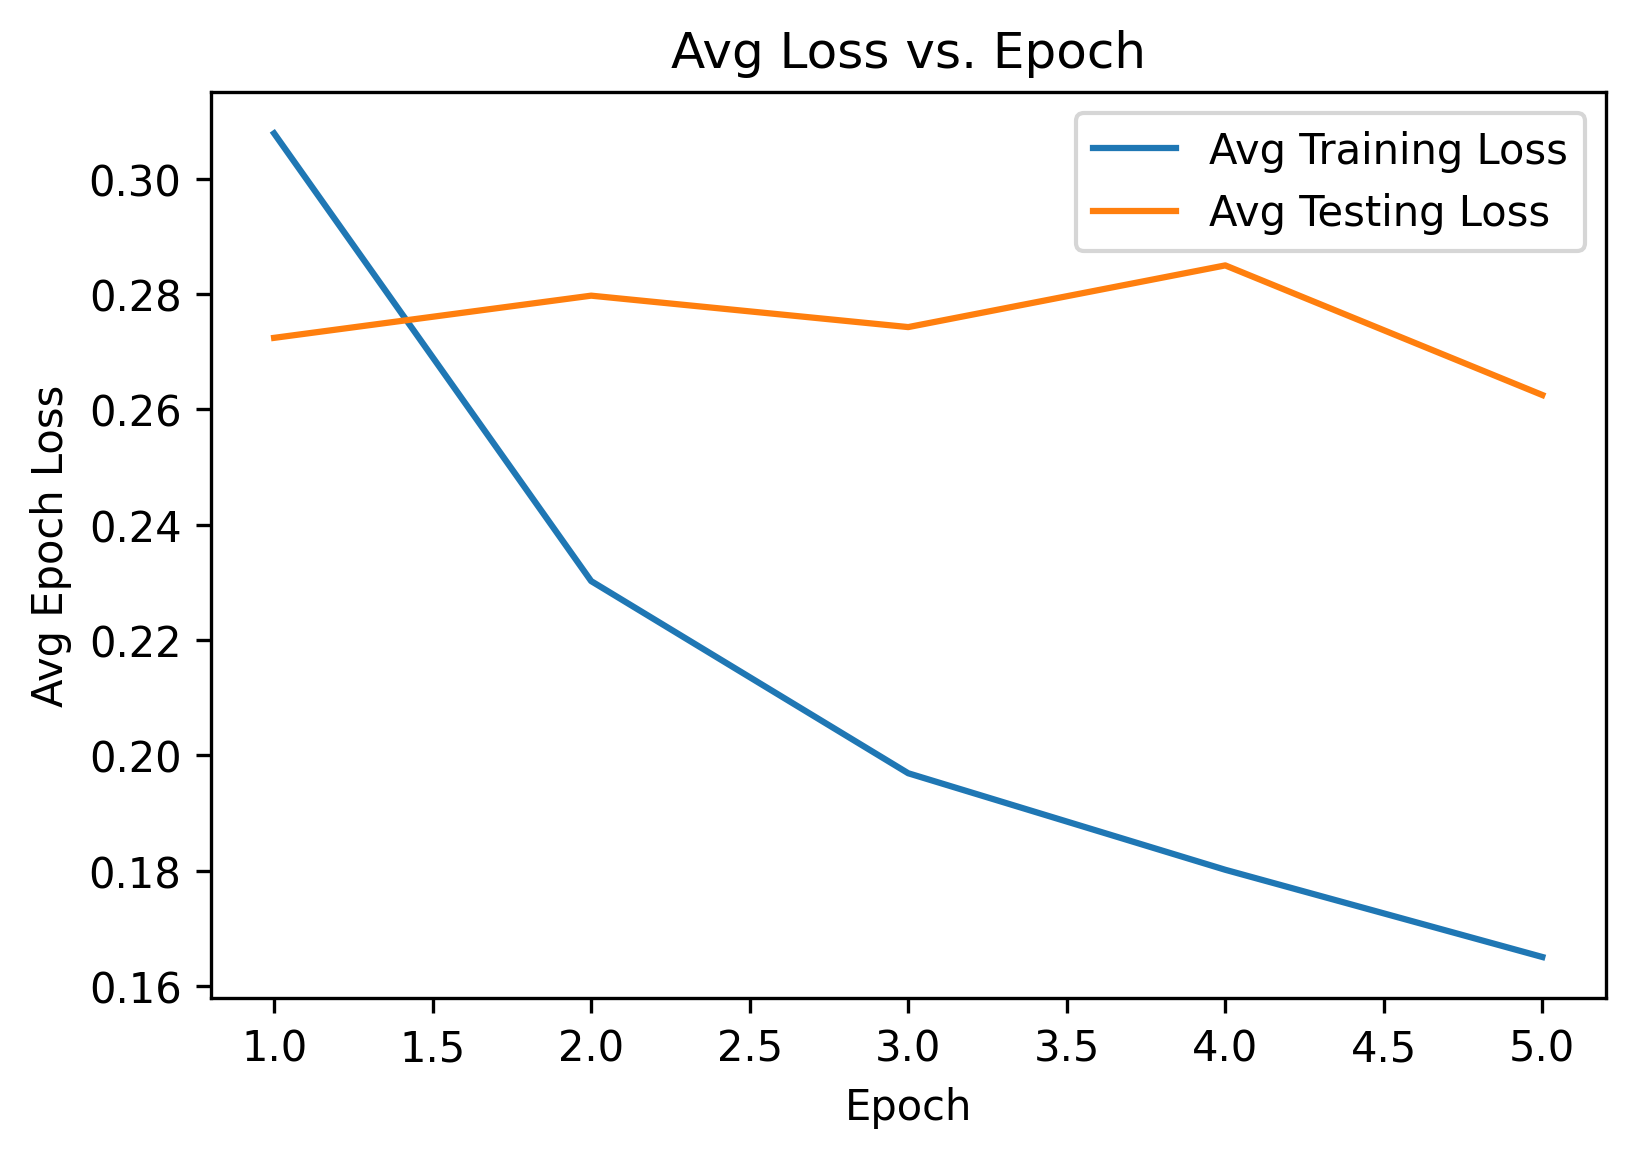

In [ ]:
import matplotlib.pyplot as plt
epochs = [1,2,3,4,5]
plt.figure(dpi=300)
plt.plot(epochs, epoch_train_losses, label = "Avg Training Loss")
plt.plot(epochs, epoch_test_losses, label = "Avg Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Avg Epoch Loss")
plt.title("Avg Loss vs. Epoch")
plt.legend()
plt.show()